<a href="https://colab.research.google.com/github/ShubhamShaswat/Flower-Recognition/blob/master/hackearth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files
import tensorflow as tf

In [0]:
URL='https://he-public-data.s3-ap-southeast-1.amazonaws.com/HE_Challenge_data.zip'

In [0]:
import requests, zipfile, io
r = requests.get(URL)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

In [6]:
!ls

data  sample_data


In [0]:
import os
BASE_DIR='data/'
train_image_dir=os.path.join(BASE_DIR,'train/')
test_image_dir=os.path.join(BASE_DIR,'test/')



In [8]:
print('Train imaes len',len(os.listdir(train_image_dir)))
print('Test imaes len',len(os.listdir(test_image_dir)))

Train imaes len 18541
Test imaes len 2010


In [0]:
import matplotlib.image as mpimg

ncols=4
nrows=4

pic_index=0

(500, 500, 3)
(500, 500, 3)
(500, 500, 3)
(500, 500, 3)
(500, 500, 3)
(500, 500, 3)
(500, 500, 3)
(500, 500, 3)


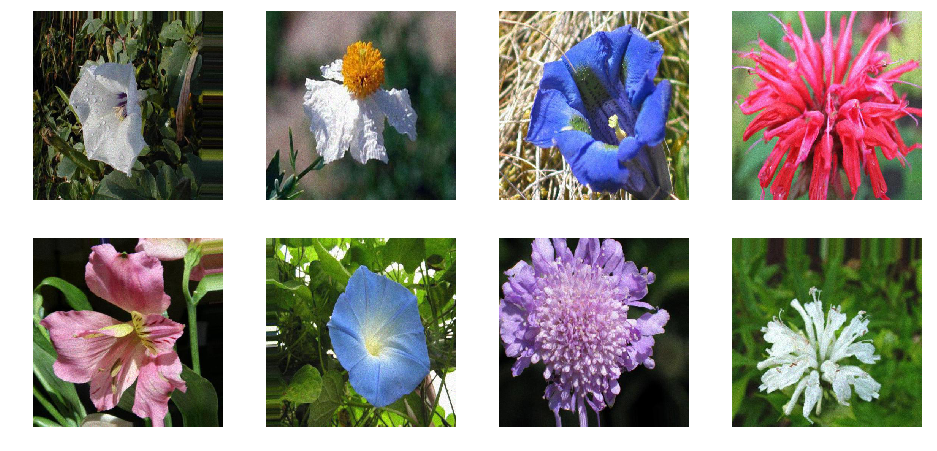

In [147]:
#plot random imaes
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

#pic_index+=8

pix = [os.path.join(train_image_dir, fname) 
                for fname in os.listdir(train_image_dir)[:8] 
               ]


for i, img_path in enumerate(pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
 
  plt.imshow(img)

plt.show()

In [0]:
#read labels from train and test
train_labels=pd.read_csv('data/train.csv')
test_labels=pd.read_csv('data/test.csv')

sample=pd.read_csv('data/sample_submission.csv')



In [144]:
sample.head()

,image_id,category
0,18540,0
1,18541,0
2,18542,0
3,18543,0
4,18544,0


In [0]:
train_labels['image_id']=train_labels['image_id'].astype(np.unicode_)
train_labels['category']=train_labels['category'].astype(np.unicode_)

In [0]:
train_labels['image_id']=train_labels['image_id']+'.jpg'

In [0]:
test_labels['image_id']=test_labels['image_id'].astype(np.unicode_)
test_labels['category']=test_labels['category'].astype(np.unicode_)
test_labels['image_id']=test_labels['image_id']+'.jpg'


In [47]:
test_labels.head()

,image_id,category
0,18540.jpg,nan
1,18541.jpg,nan
2,18542.jpg,nan
3,18543.jpg,nan
4,18544.jpg,nan


In [141]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen=ImageDataGenerator(rescale=1/255.0,validation_split=0.2)

train_data=train_datagen.flow_from_dataframe(train_labels, subset='training',directory=train_image_dir, x_col='image_id', y_col='category', target_size=(256, 256),  class_mode='categorical', batch_size=64)

validation_data=train_datagen.flow_from_dataframe(train_labels, subset='validation',directory=train_image_dir, x_col='image_id',y_col='category', target_size=(256, 256),class_mode='categorical')

  

Found 14832 validated image filenames belonging to 102 classes.
Found 3708 validated image filenames belonging to 102 classes.


In [83]:
validation_data.samples

3708

In [0]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential,Model,Input
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,Activation
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator

In [0]:
def model():
  
  #input
  X_input = Input((300,300,3))
  
  #conv 2d
  X=Conv2D(16,(3,3),activation='relu')(X_input)
  X=MaxPool2D((2,2))(X)
  
  X=Conv2D(32,(3,3),activation='relu')(X)
  X=MaxPool2D((2,2))(X)
  
  X=Conv2D(64,(3,3),activation='relu')(X)
  X=MaxPool2D((2,2))(X)
  
  X=Flatten()(X)
  
  X=Dense(512,activation='relu')(X)
  
  X=Dropout(0.5)(X)
  
  X=Dense(102,activation='softmax')(X)
  
  return Model(inputs=X_input,outputs=X)
                                       

In [0]:
#load pretarined vgg19 model
import keras
vgg19=keras.applications.vgg19.VGG19(include_top=False, weights='imagenet',input_shape = (256,256, 3))


In [137]:
vgg19.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [0]:
def vgg():
  
  for layer in vgg19.layers:
    layer.trainable = False
    
  x = vgg19.output
  x = Flatten()(x)
  x = Dense(512, activation="relu")(x)
  x = Dropout(0.5)(x)
  x = Dense(512, activation="relu")(x)
  x = Dense(102, activation="softmax")(x) 
  
  return Model(inputs=vgg19.input,outputs=x)
  
  

In [0]:
myModel=vgg()

In [0]:
myModel.compile(optimizer=RMSprop(lr=0.001),loss= "categorical_crossentropy", metrics=["accuracy"])

In [143]:
history=myModel.fit_generator(train_data, steps_per_epoch=train_data.samples//64,validation_data=validation_data,validation_steps=validation_data.samples//32,epochs=10)




Epoch 1/10
231/231 [==============================] - 241s 1s/step - loss: 15.8851 - acc: 0.0107 - val_loss: 15.8991 - val_acc: 0.0136
Epoch 2/10
231/231 [==============================] - 237s 1s/step - loss: 15.9039 - acc: 0.0130 - val_loss: 15.8769 - val_acc: 0.0150
Epoch 3/10
230/231 [============================>.] - ETA: 0s - loss: 15.9082 - acc: 0.0129

KeyboardInterrupt: ignored

In [145]:
test_datagen=ImageDataGenerator(rescale=1/255.0)

#test_data=test_datagen.flow_from_dataframe(test_labels, directory=test_image_dir, x_col='image_id', y_col='category', target_size=(300, 300),  class_mode=None)
test_data=test_datagen.flow_from_directory(directory=test_image_dir,  target_size=(300, 300),  class_mode=None)





Found 0 images belonging to 0 classes.


In [0]:
test_data.reset()

predict = myModel.predict_generator(test_data,steps=2009/32)



In [0]:
predicted_class_indices=np.argmax(predict,axis=1)

labels = (train_data.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]



In [0]:
filenames=test_data.filenames
results=pd.DataFrame({"image_id":filenames,
                      "category":predictions})

In [0]:
results['image_id']=results['image_id'].str.replace(".jpg", "")

In [0]:
results.to_csv('submission2.csv',index=False)



In [0]:
from google.colab import files
files.download('submission2.csv')